In [1]:
import numpy as np
import matplotlib.pyplot as plt
from train import make_dataloader, train_model, probe_model
from model import ValueRNN
from tasks.eshel import Eshel
from tasks.trial import RewardAmountDistribution, RewardTimingDistribution
import torch

### Setting up the experiment

In [2]:
reward_time = [8]
reward_time_probs = [1.0]

# reward_sizes = [10]
# reward_size_probs = [1]
reward_sizes = [2, 4, 6, 8]
reward_size_probs = [0.25, 0.25, 0.25, 0.25]
# reward_sizes = [.1, .3, 1.2, 2.5, 5.0, 10.0, 20.0]
# reward_size_probs = [0.06612594, 0.09090909, 0.14847358, 0.15489467, 0.31159175, 0.1509519, 0.07705306]

#since we are using only 1 cue, therefore only one distribution is required
reward_sizes_dist = [RewardAmountDistribution(reward_sizes, reward_size_probs)] 
reward_timing_dist = [RewardTimingDistribution(reward_time, reward_time_probs)]

In [3]:
E = Eshel(rew_size_distributions= reward_sizes_dist,
          rew_time_distributions=reward_timing_dist,
          cue_shown=[True],
          cue_probs=[1.0],
          ntrials=10000,
          ntrials_per_episode=20,
          iti_min=5,
          iti_p=1/8,
          iti_max=0,
          jitter=0,
          iti_dist='geometric',
          t_padding=0)

### Creating the model

In [4]:
hidden_size = 50 # number of hidden neurons
gamma = 0.93 # discount factor
model = ValueRNN(input_size=E.ncues + E.nrewards,
                 output_size=E.nrewards,
                 hidden_size=hidden_size, 
                 gamma=gamma,
                 recurrent_cell='GRU')     #choose the cell from RNN, LSTM, or GRU

print('model # parameters: {}'.format(model.n_parameters()))

model # parameters: 8151


In [5]:
epochs = 300
batch_size = 12
learning_rate = 0.003
alpha_plus = 0.05       #learning rate for positive errors
alpha_minus = 0.05      #learning rate for negative errors
# alpha_minus = 1
# alpha_plus = 1

dataloader = make_dataloader(E, batch_size=batch_size)

Epoch 0, loss: 0.1297
Epoch 25, loss: 0.0277
Epoch 50, loss: 0.0643
Epoch 75, loss: 0.0640
Epoch 100, loss: 0.0480
Epoch 125, loss: 0.0221
Epoch 150, loss: 0.0480
Epoch 175, loss: 0.0256
Epoch 200, loss: 0.0262
Epoch 225, loss: 0.0348
Epoch 250, loss: 0.0484
Epoch 275, loss: 0.0406
Epoch 300, loss: 0.0561
Done! Final loss: 0.04790736344598588
Done! Best loss: 0.02213749537865321


(<Figure size 900x900 with 1 Axes>,
 Text(0.5, 0, '# epochs'),
 Text(0, 0.5, 'loss'))

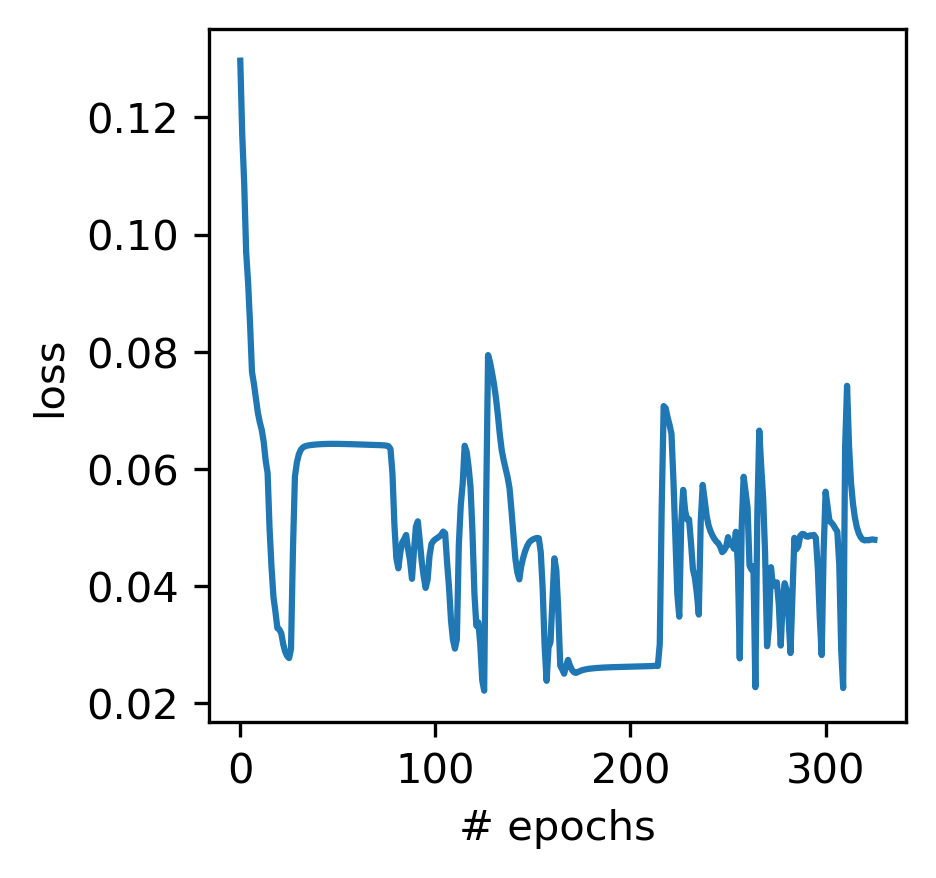

In [6]:
scores, other_scores, weights = train_model(model, dataloader, 
                                            epochs=epochs, 
                                            optimizer='SGD', 
                                            lr=learning_rate,
                                            alpha_plus = alpha_plus,
                                            alpha_minus = alpha_minus,
                                            print_every=25,
                                            use_weights='final')

plt.figure(figsize=(3,3), dpi=300), plt.plot(scores), plt.xlabel('# epochs'), plt.ylabel('loss')

In [7]:
# path_to_save = 'C:/Users/Asus/Desktop/distributional-td-learning_2/model_weights/reward=[2,4,6,8]/'

# torch.save(model.state_dict(), path_to_save+ 'model_weights' + '.pt')

### Probe the model

In [6]:
path_to_model = 'C:/Users/Asus/Desktop/distributional-td-learning_2/model_weights/reward=[2,4,6,8]/(+0.05)(-0.05).pt'
model.load_state_dict(torch.load(path_to_model))

responses = probe_model(model=model, 
                        alpha_plus=alpha_plus, 
                        alpha_minus=alpha_minus, 
                        dataloader=dataloader)[1:] # ignore first trial

In [11]:
# reward_rpe_dict = {}
# std_errors_dict = {}
# for tr in responses:
#     if tr.reward_size not in reward_rpe_dict:
#         reward_rpe_dict[tr.reward_size] = [tr.rpe[-1]]
#     else:
#         reward_rpe_dict[tr.reward_size].append(tr.rpe[-1])

# for key in reward_rpe_dict:
#     mu = np.mean(reward_rpe_dict[key])
#     std_deviation = np.std(reward_rpe_dict[key])
#     std_error = std_deviation/np.sqrt(len(reward_rpe_dict[key]))
#     std_errors_dict[key] = std_error

In [17]:
rpe_means = []
rpe_std_errors = []

for reward_size in reward_sizes:
    all_rpe = [trial.rpe[-1] for trial in responses if trial.reward_size == reward_size]
    rpe_mean = np.mean(all_rpe)
    rpe_std_error = np.std(all_rpe)/np.sqrt(len(all_rpe))
    rpe_means.append(rpe_mean)
    rpe_std_errors.append(rpe_std_error)

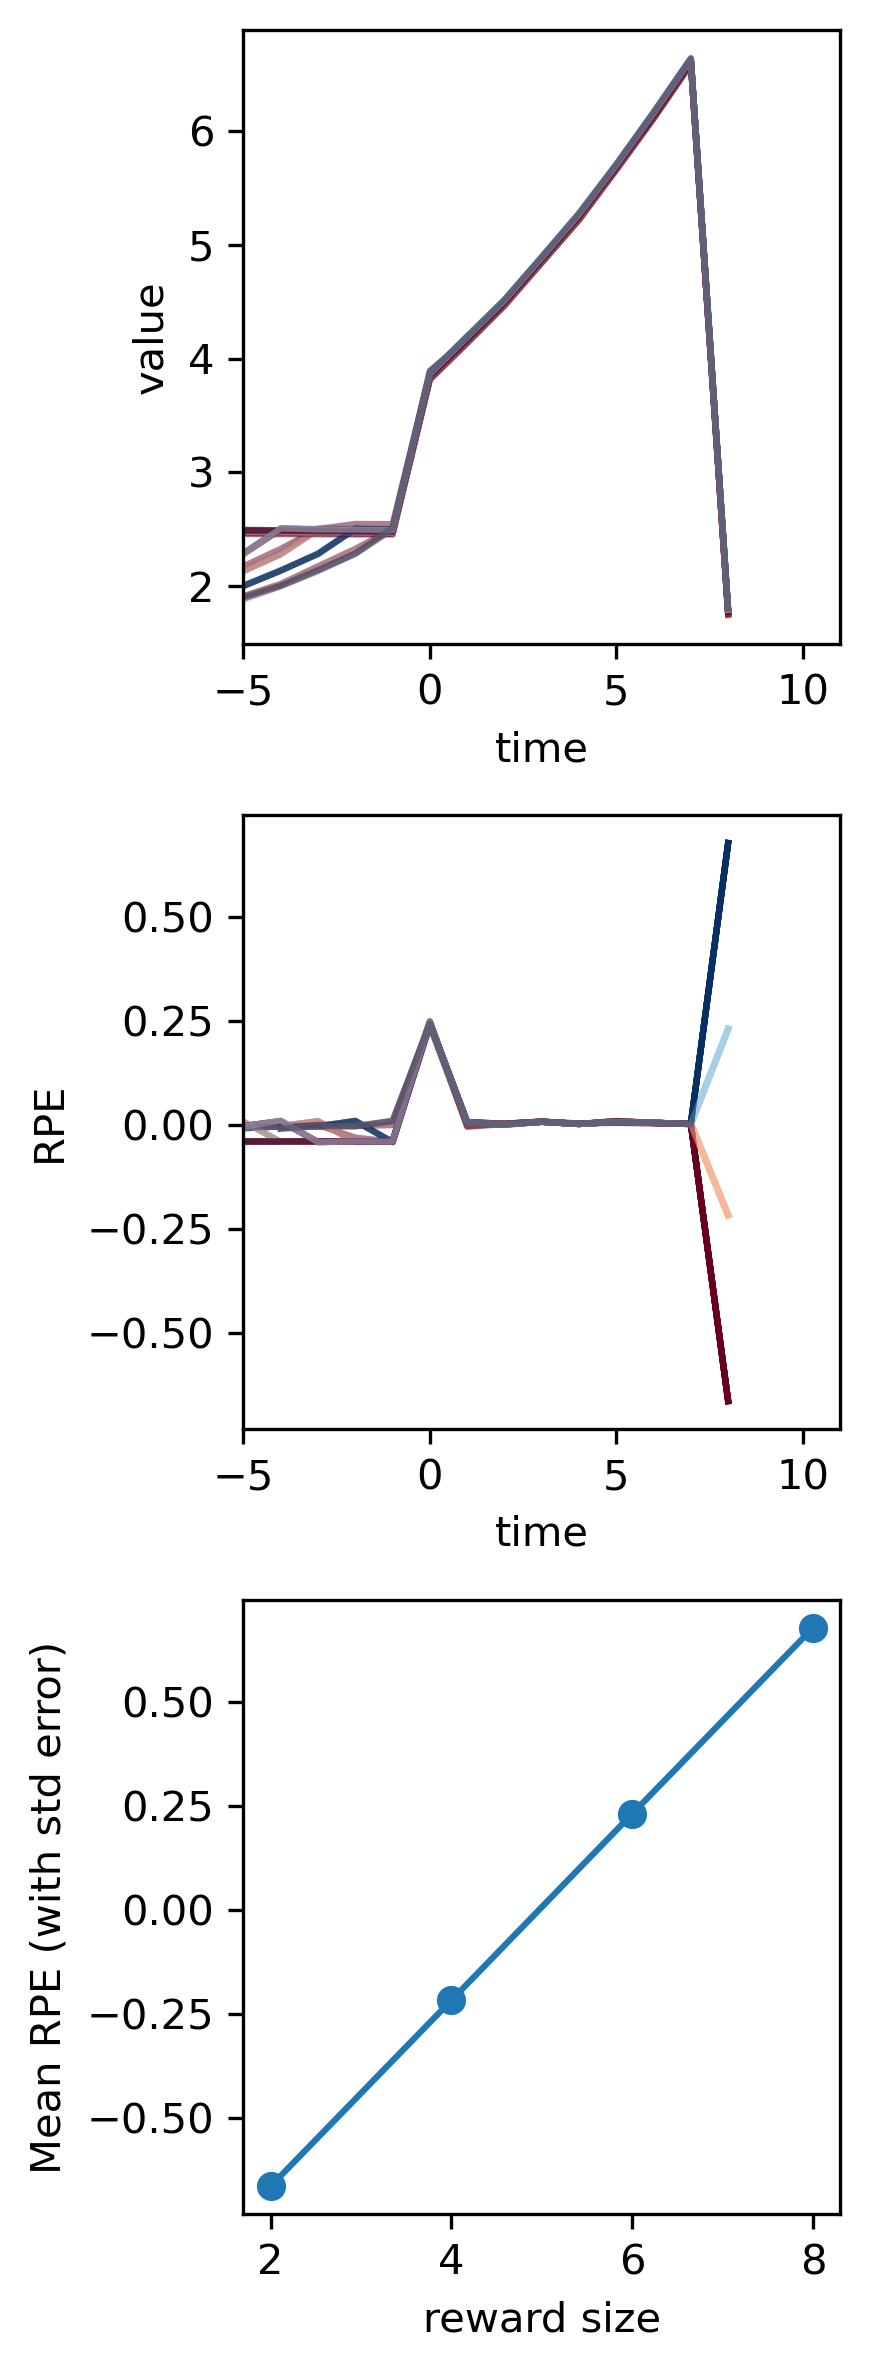

In [78]:
rsizes = E.rew_size_distributions[0].rew_sizes
clrs = {rsizes[i]: plt.cm.RdBu(i/(len(rsizes)-1)) for i in np.arange(len(rsizes))}

plt.figure(figsize=(3,8), dpi=300)
for c,trial in enumerate(responses[:50]):
    xs = np.arange(len(trial)) - trial.iti
    
    plt.subplot(3,1,1)
    plt.plot(xs, trial.value, '-', color=clrs[trial.reward_size], alpha=0.5)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.xlim([-5, 11])

    plt.subplot(3,1,2)
    plt.plot(xs[1:], trial.rpe, '-', color=clrs[trial.reward_size], alpha=0.5)
    plt.xlabel('time')
    plt.ylabel('RPE')
    plt.xlim([-5, 11])

    # plt.subplot(3,1,3)
    # plt.bar(trial.reward_size, np.mean(trial.rpe)) #, yerr=std_errors_dict[trial.reward_size])
    # plt.axhline(y=0, ls='--', color='k', linewidth=0.5, alpha=0.5)
    # plt.xlabel('reward size')
    # plt.ylabel('RPE of the trial')
    
    # plt.subplot(4,1,4)
    # plt.bar(trial.reward_size, np.mean(trial.rpe), color=clrs[trial.reward_size])
    # plt.axhline(y=0, ls='--', color='k', linewidth=0.5, alpha=0.5)
    # plt.xlabel('reward size')
    # plt.ylabel('RPE of the trial')

# y_error = np.array(rpe_means) + np.array(rpe_std_errors)
plt.subplot(3, 1, 3)
plt.errorbar(reward_sizes, rpe_means, yerr=rpe_std_errors, fmt='o-')
plt.xlabel('reward size')
plt.ylabel('Mean RPE (with std error)')

plt.tight_layout()
plt.show()

In [94]:
print(rpe_std_errors)

[1.1138989136101646e-05, 5.457579531898364e-06, 5.010370929567547e-06, 4.805023869383278e-06]


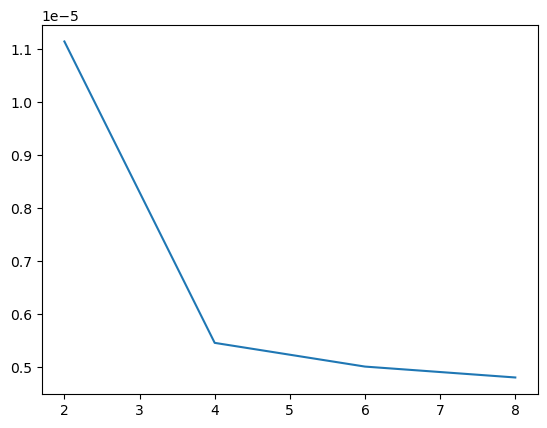

In [99]:
plt.plot(reward_sizes, rpe_std_errors)
plt.show()

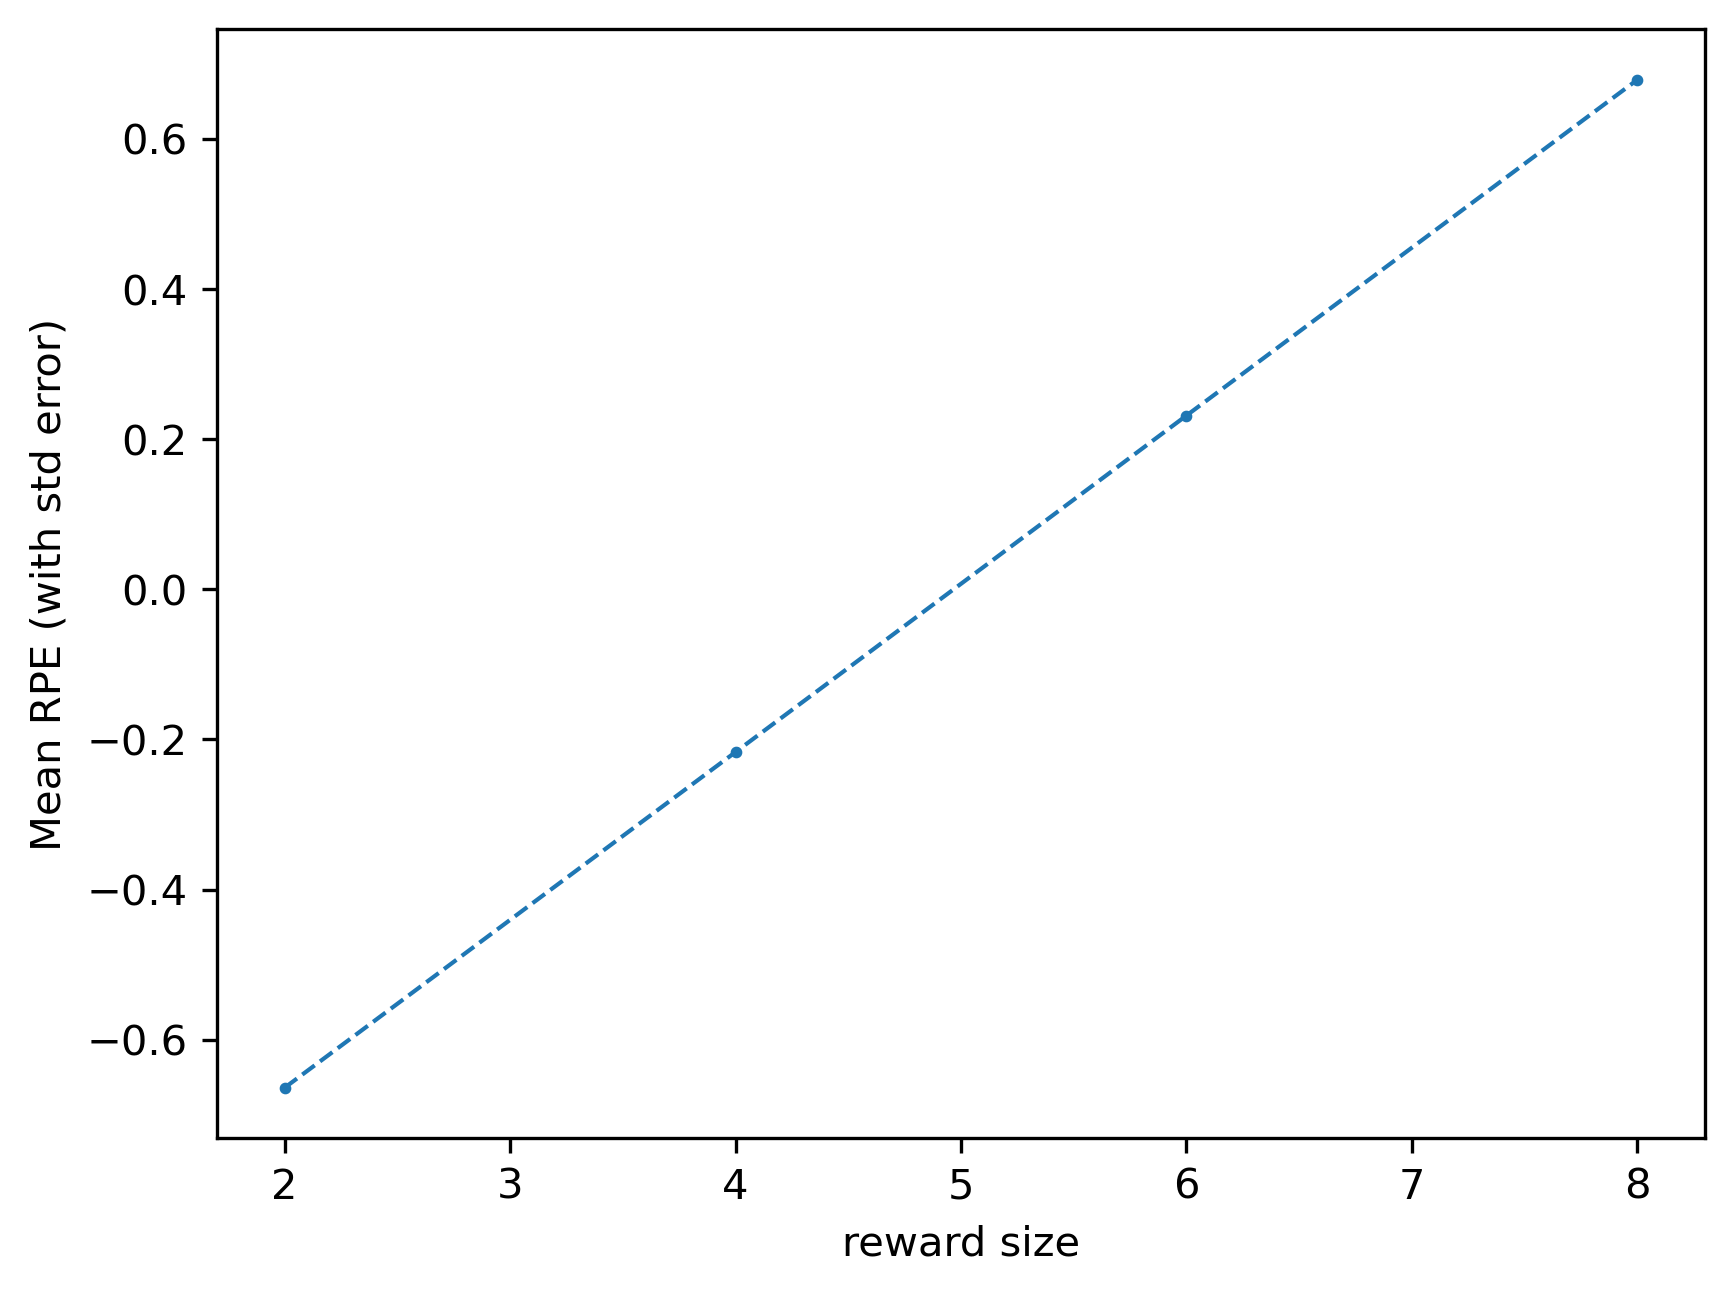

In [ ]:
fig, ax = plt.subplots(dpi=300)
ax.errorbar(reward_sizes, rpe_means, yerr=rpe_std_errors, fmt='o--', ecolor='r', ms=1.8, linewidth=1, elinewidth=20)
# plt.yscale('log')
plt.xlabel('reward size')
plt.ylabel('Mean RPE (with std error)')
# plt.ylim(-1.001, 1.00001)
plt.show()